In [46]:
from matplotlib import pyplot as plt
import platform, os, sys, pprint, h5py, emoji
from tqdm import tqdm
import numpy as np
from glob import glob
from tabulate import tabulate
from pprint import pprint
from importlib import reload
from mpl_toolkits.axes_grid.inset_locator import inset_axes

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\slab\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    import interpolate_slow
else:
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    
from Common import common, kfit
from TrapAnalysis import trap_analysis
from TrapAnalysis import artificial_anneal as anneal
from glob import glob 
from pprint import pprint
from mpltools import color

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [47]:
save_path = r"/Volumes/slab/Gerwin/Electron on helium/Electron optimization/Realistic potential/Trap signal exploration"
sub_dirs = glob(os.path.join(save_path, "170712*"))
pprint(sub_dirs)

['/Volumes/slab/Gerwin/Electron on helium/Electron optimization/Realistic '
 'potential/Trap signal '
 'exploration/170712_132553_M018V6_Electron_Number_Plot_resonator_sweep',
 '/Volumes/slab/Gerwin/Electron on helium/Electron optimization/Realistic '
 'potential/Trap signal '
 'exploration/170712_134045_M018V6_Electron_Number_Plot_resonator_sweep',
 '/Volumes/slab/Gerwin/Electron on helium/Electron optimization/Realistic '
 'potential/Trap signal '
 'exploration/170712_140046_M018V6_Electron_Number_Plot_resonator_sweep',
 '/Volumes/slab/Gerwin/Electron on helium/Electron optimization/Realistic '
 'potential/Trap signal '
 'exploration/170712_142053_M018V6_Electron_Number_Plot_resonator_sweep',
 '/Volumes/slab/Gerwin/Electron on helium/Electron optimization/Realistic '
 'potential/Trap signal '
 'exploration/170712_145954_M018V6_Electron_Number_Plot_resonator_sweep',
 '/Volumes/slab/Gerwin/Electron on helium/Electron optimization/Realistic '
 'potential/Trap signal '
 'exploration/1707

In [76]:
Vtraps = list()
num_electrons = list()
num_total_electrons = list()
e_density = list()
trap_domain_x = (18.5E-6, 21.5E-6)

for sub_dir in sub_dirs:
    converged, energy, num_trapped_electrons = list(), list(), list()
    with h5py.File(os.path.join(os.path.join(save_path, sub_dir), "Results.h5"), "r") as f:
        print("Directory: %s" % sub_dir)
        k = 0

        resVs, trapVs, resgVs, trapgVs = f["Vres"][()], f["Vtrap"][()], f["Vrg"][()], f["Vtg"][()]
        Vtraps.append(np.max(trapVs))
        
        for step in f.keys():
            if "step" in step:
                electron_ri = f[step + "/electron_final_coordinates"][()]
                xi, yi = anneal.r2xy(electron_ri)
                energy.append(f[step+"/final_energy"][()])

                valid_solution = f[step + "/solution_converged"][()]
                converged.append(valid_solution)
                if k == 0:
                    num_total_electrons.append(len(xi))
                    xi_resonator = xi[xi > 21E-6]
                    yi_resonator = yi[xi > 21E-6]
                    e_density.append(anneal.get_electron_density_by_position(anneal.xy2r(xi_resonator, yi_resonator)))
                    
                k += 1
                
                num_trapped_electrons.append(np.sum(np.logical_and(xi < trap_domain_x[1], xi > trap_domain_x[0])))
        
        num_electrons.append(num_trapped_electrons)

Directory: /Volumes/slab/Gerwin/Electron on helium/Electron optimization/Realistic potential/Trap signal exploration/170712_132553_M018V6_Electron_Number_Plot_resonator_sweep
Directory: /Volumes/slab/Gerwin/Electron on helium/Electron optimization/Realistic potential/Trap signal exploration/170712_134045_M018V6_Electron_Number_Plot_resonator_sweep
Directory: /Volumes/slab/Gerwin/Electron on helium/Electron optimization/Realistic potential/Trap signal exploration/170712_140046_M018V6_Electron_Number_Plot_resonator_sweep
Directory: /Volumes/slab/Gerwin/Electron on helium/Electron optimization/Realistic potential/Trap signal exploration/170712_142053_M018V6_Electron_Number_Plot_resonator_sweep
Directory: /Volumes/slab/Gerwin/Electron on helium/Electron optimization/Realistic potential/Trap signal exploration/170712_145954_M018V6_Electron_Number_Plot_resonator_sweep
Directory: /Volumes/slab/Gerwin/Electron on helium/Electron optimization/Realistic potential/Trap signal exploration/170712_1

/Users/gkoolstra/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


1.24202801906e+13
1.38587434583e+13
1.42200206285e+13
1.22951938571e+13
1.35171143139e+13
1.39564301829e+13
1.22325299853e+13
1.30782036845e+13
1.41469920854e+13
1.22961312727e+13
1.28511239544e+13
1.42275014982e+13


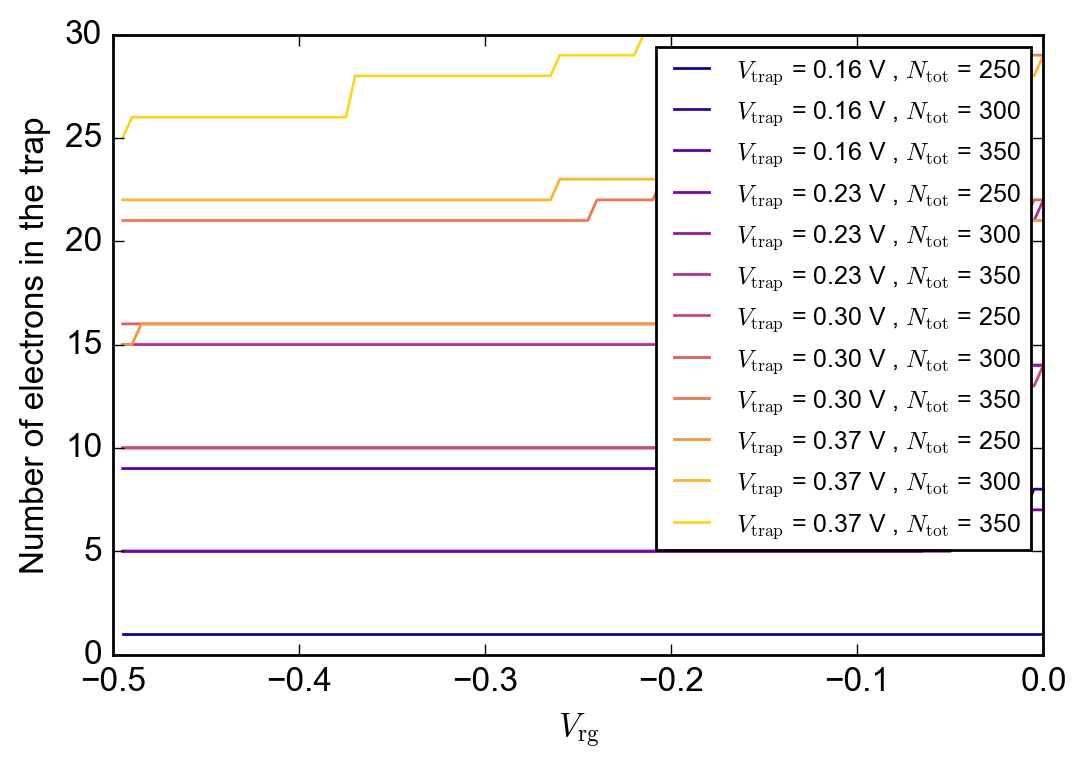

In [77]:
N=np.array(num_electrons)

plt.figure()
color.cycle_cmap(np.shape(N)[0]+1, cmap=plt.cm.plasma)
common.configure_axes(12)

ind = np.lexsort((num_total_electrons, Vtraps))

for k in ind:
    Vtraps
    plt.plot(resgVs, N[k,:], 
             label=r"$V_\mathrm{trap}$ = %.2f V , $N_\mathrm{tot}$ = %d"%(Vtraps[k], num_total_electrons[k]))
    print(e_density[k])
    
plt.ylim(0, 30)
plt.ylabel("Number of electrons in the trap")
plt.xlabel("$V_\mathrm{rg}$")
plt.legend(loc=0, prop={"size": 9})

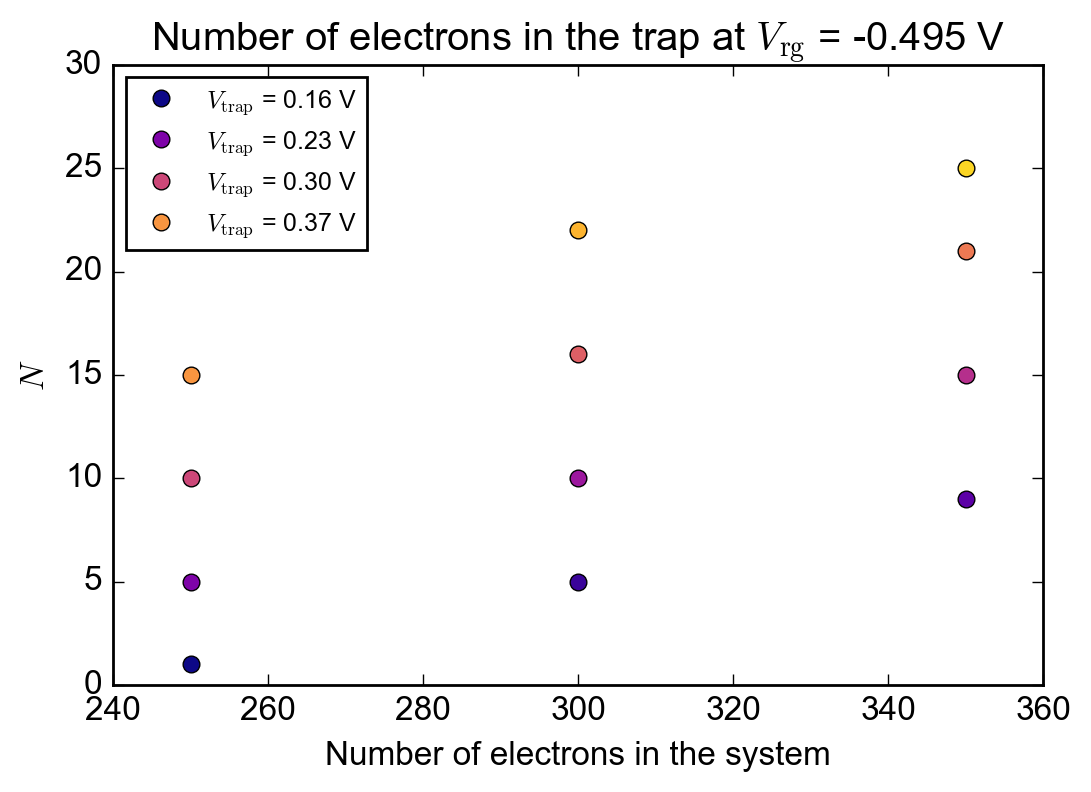

In [71]:
import matplotlib
def rgba(i, N):
    norm = matplotlib.colors.Normalize(vmin=0, vmax=N)
    cmap = plt.cm.plasma
    m = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    return m.to_rgba(i)

fig = plt.figure()

for i,k in enumerate(ind):
    if not(i%3): 
        label=r"$V_\mathrm{trap}$ = %.2f V"%(Vtraps[k])
    else:
        label=""
    plt.plot(num_total_electrons[k], N[k,-1], 'o', label=label, color=rgba(i, len(ind)))
    
plt.ylim(0, 30)
plt.title("Number of electrons in the trap at $V_\mathrm{rg}$ = %.3f V"%resgVs[-1])
plt.xlabel("Number of electrons in the system")
plt.ylabel("$N$")
plt.legend(loc=0, prop={"size": 9}, numpoints=1)

# common.save_figure(fig, save_path=r"/Users/gkoolstra/Documents/Code/iPythonNotebooks/Figures")